# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [1]:
#%matplotlib notebook
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from jax import grad
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/")

In [3]:
from mecll import dynamics
from mecll.dynamics import predict_all, get_basis_tensor, grad_wrapper, caley_transform, get_spatial_tuning

In [4]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2)
act_matrix, act_matrix2, space_order2, space_order2_inv = sim_res

ValueError: too many values to unpack (expected 4)

In [5]:
act_matrix2 = act_matrix2[space_order2_inv]

NameError: name 'act_matrix2' is not defined

In [ ]:
n_neurons = act_matrix.shape[1]

In [ ]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [12]:
REMOVE_SPACE = False

In [13]:
if REMOVE_SPACE:
    spatial_response = (act_matrix + act_matrix2[space_order2_inv])/2.
    act_matrix2 = act_matrix2 - spatial_response[space_order2]
    act_matrix = act_matrix - spatial_response

In [14]:
#grad_predict_all = grad(predict_all)

In [15]:
from sklearn.decomposition import PCA

In [17]:
pca_dim = 5
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [18]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,pca_dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [19]:
o = np.random.permutation(np.arange(9))
np.allclose(act_matrix[o][:,1],act_matrix[:,1][o])

True

In [20]:
print(res.fun,res.message)

10.171995 Desired error not necessarily achieved due to precision loss.


In [21]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [22]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

In [23]:
#predicted_neural_activity = pca.inverse_transform(pca_activity)

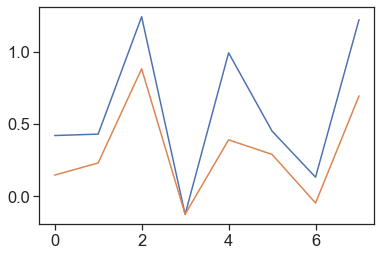

In [24]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix[:,ix_][1:])

In [25]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.mean(cc))

0.9379751526213645


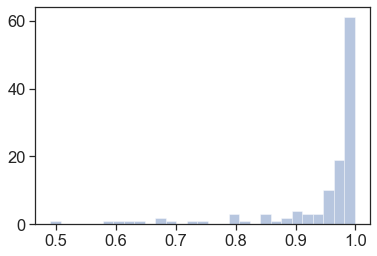

In [26]:
seaborn.distplot(cc,kde=0)

## Now look at the held out task

In [27]:

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [28]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

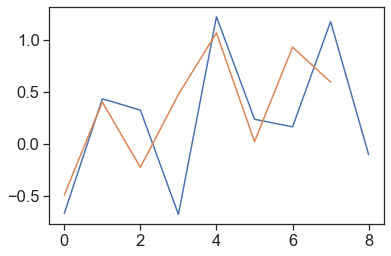

In [29]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix2[:,ix_][1:])

In [30]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
print(np.mean(cc))

0.8208241708612033


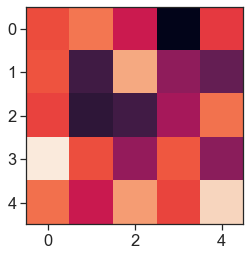

In [31]:
plt.imshow(A)

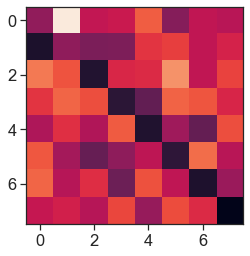

In [28]:
plt.imshow(Ainf)

# Now run actual clean test

In [4]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    true_cc = np.nanmean(true_cc)
    return np.nanmean(true_cc)

In [81]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca,NFITS=5,NSHUFF=2000):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(NFITS):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
        
    params = fit_params[np.argmax(fit_quality)]
    skewM = np.einsum('i...,i...',params,basis_tensor_inf)
    Ainf = caley_transform(skewM,pca_dim)
    print(fit_quality)
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(NSHUFF):
        
        perm_order = np.random.permutation(r9)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)

        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)
        shuffle_res.append(shf_res)
    return res, shuffle_res, Ainf
    

In [78]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=1,noise_scale=0)
act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
act_matrix2 = act_matrix2[task_order2_inv]

In [79]:
pca_dim = 8
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [76]:
res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)

KeyboardInterrupt: 

In [77]:
real_res = res[0]
shuffle_res = res[1]

In [88]:
all_res_only_space = []
for _ in range(8):

    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=1,noise_scale=0)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]    
    act_matrix = act_matrix - np.mean(act_matrix,axis=0)
    act_matrix2 = act_matrix2 - np.mean(act_matrix2,axis=0)

    pca_dim = 8
    pca = PCA(n_components=pca_dim)


    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)
    all_res_only_space.append(res)

[0.8465878639932318, 0.846558449732042, 0.7994337691806636, 0.8466554539009977, 0.773222055164158]
0.12481899199702377
[0.7479637000306539, 0.8153107391782146, 0.8153162501464808, 0.7334556204997332, 0.8153615620088892]
0.17908351892953547
[0.5921941600243457, 0.6904506003422114, 0.5837034306176597, 0.615957664542335, 0.8116163289358928]
-0.0025997541260461047
[0.8080506919118196, 0.7496826359317318, 0.8079842821032927, 0.808052241114656, 0.8080521600270281]
0.01889803579294018
[0.657418760197796, 0.7726075829766383, 0.7643924849312879, 0.8327023246558457, 0.8326134368173774]
0.08333916482738019
[0.7266773014602592, 0.819451146088014, 0.7526894749531067, 0.48494492981060106, 0.8195072463839229]
0.050788151987668576
[0.8113218509099664, 0.8113321377476183, 0.811318962185961, 0.8110250438820343, 0.6327585706239709]
-0.022498408452052174
[0.8274627369898864, 0.8274640810200483, 0.7232518269361736, 0.8274644123252035, 0.8274668388829077]
-0.15247415178488793


In [84]:
all_res_with_space = []
for _ in range(8):

    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=None,noise_scale=0)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]    
    
    act_matrix = act_matrix - np.mean(act_matrix,axis=0)
    act_matrix2 = act_matrix2 - np.mean(act_matrix2,axis=0)
    
    pca_dim = 8
    pca = PCA(n_components=pca_dim)


    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)
    all_res_with_space.append(res)

[0.8070583787157524, 0.8097472209843981, 0.7962315685205624, 0.759927437776444, 0.7510394335673568]
0.6197734871223985
[0.7987028364672663, 0.6716155280648543, 0.8299357721490208, 0.8300363283201809, 0.8300211403822789]
0.09798923986945463
[0.9598323645004944, 0.9544671125529917, 0.9610390044588567, 0.9606877871028051, 0.9602040127920777]
0.6441799691269326
[0.9512532261166804, 0.9418140391713077, 0.9494309551111328, 0.9451650781941616, 0.9524586362367999]
0.8692007372346762
[0.6579995509530931, 0.7956627336005034, 0.6512305793594748, 0.8455542940677563, 0.6416918492652604]
0.17438222760676528
[0.7961385699830394, 0.7862029769423357, 0.776031775225255, 0.8008135768173653, 0.7863761780018711]
0.662836064859434
[0.8629158173323842, 0.8632996876078188, 0.776543062943251, 0.8587205887273607, 0.8587136256571388]
0.307060242425871
[0.9324977692737273, 0.917861039451747, 0.7821290613411265, 0.9155990186555802, 0.9216316029986247]
0.5923525874543335


In [85]:
real_res = [i[0] for i in  all_res_with_space]
shuffle_res = [i[1] for i in  all_res_with_space]

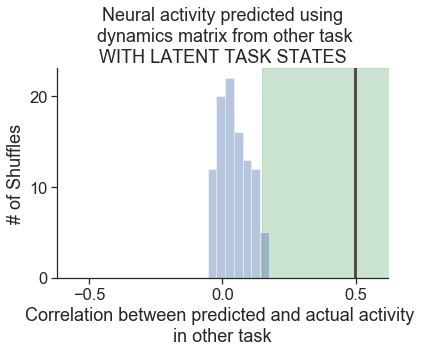

In [86]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITH LATENT TASK STATES")

real_res = [i[0] for i in  all_res_with_space]
shuffle_res = [i[1] for i in  all_res_with_space]

seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt
plt.tight_layout()

In [87]:
np.mean(np.nanmean(np.array(shuffle_res),axis=0))

0.041397284788795764

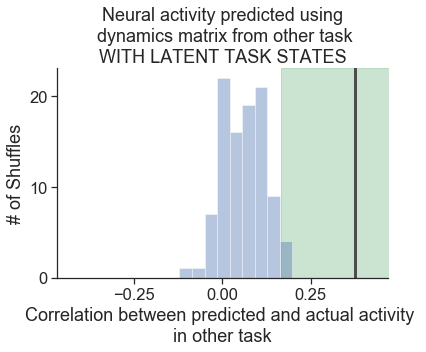

In [71]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITH LATENT TASK STATES")

real_res = [i[0] for i in  all_res_with_space]
shuffle_res = [i[1] for i in  all_res_with_space]

seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

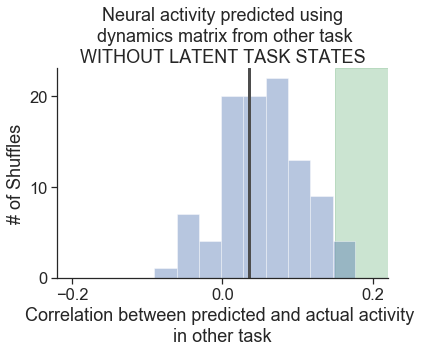

In [89]:
real_res = [i[0] for i in  all_res_only_space]
shuffle_res = [i[1] for i in  all_res_only_space]
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITHOUT LATENT TASK STATES")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

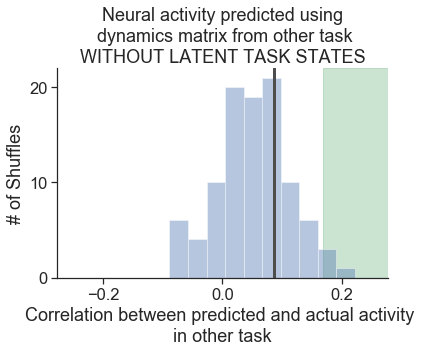

In [83]:
real_res = [i[0] for i in  all_res_only_space]
shuffle_res = [i[1] for i in  all_res_only_space]
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITHOUT LATENT TASK STATES")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [55]:
[real_res,np.max(np.nanmean(np.array(shuffle_res),axis=0))]

[[0.59729441165493,
  0.5160248679746946,
  0.336812336649562,
  0.5075610710859012,
  0.7420509497446887,
  0.2957632683511617,
  -0.027165728846548973,
  0.033173566360357204],
 0.1978533194235353]

ValueError: color kwarg must have one color per data set. 2000 data sets and 1 colors were provided

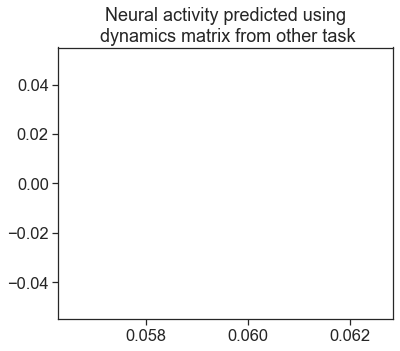

In [52]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(shuffle_res,kde=0)
plt.axvline(x=real_res,color='.3',linewidth=3)
#plt.annota
seaborn.despine()
#plt.xlim(-1,1)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(shuffle_res,97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [ ]:
all_res_only_space = []
for _ in range(8):
    #np.random.seed(99)
    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.,)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=np.random.normal(size=x2.shape),frac_space=None)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]
    
    pca_dim = 8
    pca = PCA(n_components=pca_dim)

    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)
    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=2000)
    all_res_only_space.append(res)